In [3]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [30]:
!ls drive/bowl/models

albunet32.pth  albunet.pth  starterkit.pth  unet16.pth


In [0]:
!mkdir bowl/

In [0]:
!mkdir bowl/stage1_train/

In [0]:
!mkdir bowl/stage1_test/

In [0]:
!unzip drive/bowl/stage1_train.zip -d bowl/stage1_train/

In [0]:
!unzip drive/bowl/stage1_test.zip -d bowl/stage1_test/

In [10]:
def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)


class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()

        self.block = nn.Sequential(
            ConvRelu(in_channels, middle_channels),
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)


class UNet11(nn.Module):
    def __init__(self, num_filters=32, pretrained=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network is used
            True  - encoder is pre-trained with VGG11
        """
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = models.vgg11(pretrained=pretrained).features

        self.relu = self.encoder[1]
        self.conv1 = self.encoder[0]
        self.conv2 = self.encoder[3]
        self.conv3s = self.encoder[6]
        self.conv3 = self.encoder[8]
        self.conv4s = self.encoder[11]
        self.conv4 = self.encoder[13]
        self.conv5s = self.encoder[16]
        self.conv5 = self.encoder[18]

        self.center = DecoderBlock(num_filters * 8 * 2, num_filters * 8 * 2, num_filters * 8)
        self.dec5 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 8)
        self.dec4 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 4)
        self.dec3 = DecoderBlock(num_filters * (8 + 4), num_filters * 4 * 2, num_filters * 2)
        self.dec2 = DecoderBlock(num_filters * (4 + 2), num_filters * 2 * 2, num_filters)
        self.dec1 = ConvRelu(num_filters * (2 + 1), num_filters)

        self.final = nn.Conv2d(num_filters, 1, kernel_size=1)

    def forward(self, x):
        conv1 = self.relu(self.conv1(x))
        conv2 = self.relu(self.conv2(self.pool(conv1)))
        conv3s = self.relu(self.conv3s(self.pool(conv2)))
        conv3 = self.relu(self.conv3(conv3s))
        conv4s = self.relu(self.conv4s(self.pool(conv3)))
        conv4 = self.relu(self.conv4(conv4s))
        conv5s = self.relu(self.conv5s(self.pool(conv4)))
        conv5 = self.relu(self.conv5(conv5s))

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))
        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))
        return self.final(dec1)


def unet11(pretrained=False, **kwargs):
    """
    pretrained:
            False - no pre-trained network is used
            True  - encoder is pre-trained with VGG11
            carvana - all weights are pre-trained on
                Kaggle: Carvana dataset https://www.kaggle.com/c/carvana-image-masking-challenge
    """
    model = UNet11(pretrained=pretrained, **kwargs)

    if pretrained == 'carvana':
        state = torch.load('TernausNet.pt')
        model.load_state_dict(state['model'])
    return model


class DecoderBlockV2(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlockV2, self).__init__()
        self.in_channels = in_channels

        if is_deconv:
            """
                Paramaters for Deconvolution were chosen to avoid artifacts, following
                link https://distill.pub/2016/deconv-checkerboard/
            """

            self.block = nn.Sequential(
                ConvRelu(in_channels, middle_channels),
                nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2,
                                   padding=1),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear'),
                ConvRelu(in_channels, middle_channels),
                ConvRelu(middle_channels, out_channels),
            )

    def forward(self, x):
        return self.block(x)


class AlbuNet(nn.Module):
    """
        UNet (https://arxiv.org/abs/1505.04597) with Resnet34(https://arxiv.org/abs/1512.03385) encoder
        Proposed by Alexander Buslaev: https://www.linkedin.com/in/al-buslaev/
        """

    def __init__(self, num_classes=1, num_filters=32, pretrained=False, is_deconv=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network is used
            True  - encoder is pre-trained with resnet34
        :is_deconv:
            False: bilinear interpolation is used in decoder
            True: deconvolution is used in decoder
        """
        super().__init__()
        self.num_classes = num_classes

        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = torchvision.models.resnet34(pretrained=pretrained)

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(self.encoder.conv1,
                                   self.encoder.bn1,
                                   self.encoder.relu,
                                   self.pool)

        self.conv2 = self.encoder.layer1

        self.conv3 = self.encoder.layer2

        self.conv4 = self.encoder.layer3

        self.conv5 = self.encoder.layer4

        self.center = DecoderBlockV2(512, num_filters * 8 * 2, num_filters * 8, is_deconv)

        self.dec5 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec4 = DecoderBlockV2(256 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec3 = DecoderBlockV2(128 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv)
        self.dec2 = DecoderBlockV2(64 + num_filters * 2, num_filters * 2 * 2, num_filters * 2 * 2, is_deconv)
        self.dec1 = DecoderBlockV2(num_filters * 2 * 2, num_filters * 2 * 2, num_filters, is_deconv)
        self.dec0 = ConvRelu(num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))

        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(dec2)
        dec0 = self.dec0(dec1)

        if self.num_classes > 1:
            x_out = F.log_softmax(self.final(dec0), dim=1)
        else:
            x_out = self.final(dec0)

        return x_out


class UNet16(nn.Module):
    def __init__(self, num_classes=1, num_filters=32, pretrained=False, is_deconv=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network used
            True - encoder pre-trained with VGG16
        :is_deconv:
            False: bilinear interpolation is used in decoder
            True: deconvolution is used in decoder
        """
        super().__init__()
        self.num_classes = num_classes

        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = torchvision.models.vgg16(pretrained=pretrained).features

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(self.encoder[0],
                                   self.relu,
                                   self.encoder[2],
                                   self.relu)

        self.conv2 = nn.Sequential(self.encoder[5],
                                   self.relu,
                                   self.encoder[7],
                                   self.relu)

        self.conv3 = nn.Sequential(self.encoder[10],
                                   self.relu,
                                   self.encoder[12],
                                   self.relu,
                                   self.encoder[14],
                                   self.relu)

        self.conv4 = nn.Sequential(self.encoder[17],
                                   self.relu,
                                   self.encoder[19],
                                   self.relu,
                                   self.encoder[21],
                                   self.relu)

        self.conv5 = nn.Sequential(self.encoder[24],
                                   self.relu,
                                   self.encoder[26],
                                   self.relu,
                                   self.encoder[28],
                                   self.relu)

        self.center = DecoderBlockV2(512, num_filters * 8 * 2, num_filters * 8, is_deconv)

        self.dec5 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec4 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec3 = DecoderBlockV2(256 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv)
        self.dec2 = DecoderBlockV2(128 + num_filters * 2, num_filters * 2 * 2, num_filters, is_deconv)
        self.dec1 = ConvRelu(64 + num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(self.pool(conv1))
        conv3 = self.conv3(self.pool(conv2))
        conv4 = self.conv4(self.pool(conv3))
        conv5 = self.conv5(self.pool(conv4))

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))

        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))

        if self.num_classes > 1:
            x_out = F.log_softmax(self.final(dec1), dim=1)
        else:
            x_out = self.final(dec1)

        return x_out

NameError: ignored

In [0]:
class LossBinary:
    """
    Loss defined as BCE - log(soft_jaccard)
    Vladimir Iglovikov, Sergey Mushinskiy, Vladimir Osin,
    Satellite Imagery Feature Detection using Deep Convolutional Neural Network: A Kaggle Competition
    arXiv:1706.06169
    """

    def __init__(self, jaccard_weight=0):
        self.nll_loss = nn.BCEWithLogitsLoss()
        self.jaccard_weight = jaccard_weight

    def __call__(self, outputs, targets):
        loss = self.nll_loss(outputs, targets)

        if self.jaccard_weight:
            eps = 1e-15
            jaccard_target = (targets == 1).float()
            jaccard_output = F.sigmoid(outputs)

            intersection = (jaccard_output * jaccard_target).sum()
            union = jaccard_output.sum() + jaccard_target.sum()

            loss -= self.jaccard_weight * torch.log((intersection + eps) / (union - intersection + eps))
        return loss

In [0]:
class Rescale(object):
    """Rescale the image in a sample to a given size.
    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size, train=True):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        self.train = train

    def __call__(self, sample):
        if self.train:
            image, mask, img_id, height, width = sample['image'], sample['mask'], sample['img_id'], sample['height'],sample['width']

            if isinstance(self.output_size, int):
                new_h = new_w = self.output_size
            else:
                new_h, new_w = self.output_size

            new_h, new_w = int(new_h), int(new_w)

            # resize the image,
            # preserve_range means not normalize the image when resize
            img = transform.resize(image, (new_h, new_w), preserve_range=True, mode='constant')
            mask = transform.resize(mask, (new_h, new_w), preserve_range=True, mode='constant')
            return {'image': img, 'mask': mask, 'img_id': img_id, 'height':height, 'width':width}
        else:
            image, img_id, height,width = sample['image'], sample['img_id'], sample['height'],sample['width']
            if isinstance(self.output_size, int):
                new_h = new_w = self.output_size
            else:
                new_h, new_w = self.output_size

            new_h, new_w = int(new_h), int(new_w)

            # resize the image,
            # preserve_range means not normalize the image when resize
            img = transform.resize(image, (new_h, new_w), preserve_range=True, mode='constant')
            return {'image': img, 'height': height,'width':width, 'img_id':img_id}

In [11]:
!pip install telepyth

  Running setup.py bdist_wheel for telepyth ... - done
  Stored in directory: /content/.cache/pip/wheels/cc/de/cb/7b37e1991ad8586cc8e8be593c65e6bfc92c1f485442aae3bc
Successfully built telepyth


In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision

In [0]:
import pandas as pd
import numpy as np

import cv2
import os

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from torchvision import transforms, utils
from skimage import io, transform

In [0]:
model_path = "drive/bowl/models/"
submission_path = "drive/bowl/submissions/"
model_name = "starterkit2"
model_file = model_name + '.pth'
submission_file = model_name + '.csv'

In [0]:
TRAIN_DIR = 'bowl/stage1_train/'

train_ids = os.listdir(TRAIN_DIR)
train_images = [os.path.join(TRAIN_DIR, train_id, 'images', train_id + '.png') 
                for train_id in train_ids]
train_masks = {train_id: [os.path.join(TRAIN_DIR, train_id, 'masks', img_name) 
                          for img_name in os.listdir(os.path.join(TRAIN_DIR, train_id, 'masks'))]
               for train_id in train_ids}

In [0]:
from torch.utils.data import *
class DSB2018Dataset(Dataset):
    def __init__(self, root_dir, img_id, train=True, transform=None):
        """
        Args:
        :param root_dir (string): Directory with all the images
        :param img_id (list): lists of image id
        :param train: if equals true, then read training set, so the output is image, mask and imgId
                      if equals false, then read testing set, so the output is image and imgId
        :param transform (callable, optional): Optional transform to be applied on a sample
        """
        self.root_dir = root_dir
        self.img_id = img_id
        self.train = train
        self.transform = transform
        

    def __len__(self):
        return len(self.img_id)

    def __getitem__(self, idx):
        if self.train:
            img_dir = os.path.join(TRAIN_DIR, self.img_id[idx], 'images', self.img_id[idx] + '.png')
            img = cv2.imread(img_dir)
            mask = sum((cv2.imread(train_mask)[..., 0] for train_mask in train_masks[self.img_id[idx]]))
            mask = np.expand_dims(mask, axis=-1)
            sample = {'image':img, 'mask':mask, 'img_id':self.img_id[idx], "height":img.shape[0], "width":img.shape[1]}

        else:
            img_dir = os.path.join(self.root_dir, self.img_id[idx], 'images', self.img_id[idx] + '.png')
            img = cv2.imread(img_dir)
            # size = (img.shape[0],img.shape[1])  # (Height, Weidth)
            sample = {'image': img, 'img_id': self.img_id[idx], "height":img.shape[0], "width":img.shape[1]}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [0]:
train_dataset = DSB2018Dataset(root_dir = TRAIN_DIR, img_id = train_ids)

In [0]:
model = nn.Sequential(nn.Conv2d(3, 16, (11, 11), padding=5),
                      nn.ReLU(),
                      nn.Conv2d(16, 16, (5, 5), padding=2),
                      nn.ReLU(),
                      nn.Conv2d(16, 1, (5, 5), padding=2),
                      nn.Sigmoid())

In [0]:
#model = AlbuNet(pretrained=True)

In [0]:
model = torch.load(model_path + model_file)

In [0]:
from telepyth import TelepythClient

In [10]:
tp = TelepythClient(token="3105941719605529941")
tp.send_text("Training on " + model_name)

200

In [0]:
N_EPOCHS = 60
BATCH_SIZE = 32

optimizer = Adam(model.parameters(), lr=0.00025)
model.cuda()
model.train()
losses = []
for epoch in range(N_EPOCHS):
    report_ep = "Epoch[{}]".format(epoch)
    tp.send_text(report_ep)
    print("Epoch[{}]".format(epoch))
    b = 0
    i = 0
    avg_loss = 0
    batch_num = 0
    optimizer.zero_grad()
    for tr in train_dataset:
        batch_x = np.expand_dims(np.swapaxes(tr['image'], 0, 2), 0) / 255.0
        batch_x = Variable(torch.FloatTensor(batch_x).cuda())

        batch_y = np.expand_dims(np.swapaxes(tr['mask'], 0, 1), 0) / 255.0
        batch_y = Variable(torch.FloatTensor(batch_y).cuda())
        
        prediction = model(batch_x)[:, 0]

        loss = F.binary_cross_entropy(prediction, batch_y)
        avg_loss = 0.9 * avg_loss + 0.1 * loss.data[0]
        loss = loss / BATCH_SIZE
        loss.backward()
        
        avg_loss = 0.9 * avg_loss + 0.1 * loss.data[0]
        losses.append(avg_loss)
        
        if i % BATCH_SIZE == BATCH_SIZE - 1:
            report_b = "Batch #{}; Loss:{}".format(b, avg_loss)
            if b % 10 == 0:
              tp.send_text(report_b)
            print(report_b)
            b += 1
            optimizer.step()
            i = -1
            optimizer.zero_grad()
        i += 1
    if (avg_loss < best_loss):
      best_loss = avg_loss
      report_loss = "Epoch last loss - {}. Loss improved; Model Saved as {}".format(avg_loss, model_path + model_file)
      torch.save(model, model_path + model_file)
      print(report_loss)
      tp.send_text(report_loss)
    else:
      report_loss = "Epoch last loss - {}. Not an improvement".format(avg_loss)
      print(report_loss)
      tp.send_text(report_loss)

report_end = "Training ended"
print(report_end)
tp.send_text(report_end)

Epoch[0]


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([1, 360, 360, 1])) that is different to the input size (torch.Size([1, 360, 360])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([1, 256, 256, 1])) that is different to the input size (torch.Size([1, 256, 256])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([1, 696, 520, 1])) that is different to the input size (torch.Size([1, 696, 520])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/usr/local

Batch #0; Loss:0.04725679433803718
Batch #1; Loss:0.06005329259922526


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([1, 1024, 1024, 1])) that is different to the input size (torch.Size([1, 1024, 1024])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch #2; Loss:0.05391581627965605


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([1, 347, 260, 1])) that is different to the input size (torch.Size([1, 347, 260])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch #3; Loss:0.07160344311924662
Batch #4; Loss:0.035961199565699334
Batch #5; Loss:0.0692427763966066


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([1, 1388, 1040, 1])) that is different to the input size (torch.Size([1, 1388, 1040])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([1, 1272, 603, 1])) that is different to the input size (torch.Size([1, 1272, 603])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch #6; Loss:0.0671970221678107
Batch #7; Loss:0.07713553536835838
Batch #8; Loss:0.07548852565348925
Batch #9; Loss:0.06331306524828871
Batch #10; Loss:0.037723787222312434
Batch #11; Loss:0.061137973875245485
Batch #12; Loss:0.07822032547175327
Batch #13; Loss:0.0629876016028676
Batch #14; Loss:0.05206356199156774
Batch #15; Loss:0.048395353338870975
Batch #16; Loss:0.0644248829344763
Batch #17; Loss:0.07565476633729326
Batch #18; Loss:0.04621131457397072
Batch #19; Loss:0.03707532348157944
Epoch last loss - 0.031192076787515. Loss improved; Model Saved as drive/bowl/models/starterkit2.pth
Epoch[1]
Batch #0; Loss:0.04421250492495922
Batch #1; Loss:0.052953786480424515
Batch #2; Loss:0.053170016636851544
Batch #3; Loss:0.0773586235207761
Batch #4; Loss:0.04256035637733606
Batch #5; Loss:0.061071451598769484
Batch #6; Loss:0.056967688178716364
Batch #7; Loss:0.08161253896087804
Batch #8; Loss:0.07283839300308786
Batch #9; Loss:0.06458929262804454
Batch #10; Loss:0.038163574745510694


Batch #13; Loss:0.06507442129724011
Batch #14; Loss:0.0520129145848961
Batch #15; Loss:0.047422782837087195
Batch #16; Loss:0.06232009578705585


In [0]:
model1 = torch.load(model_path + model_file)

In [0]:
np_losses = np.array(losses)

In [0]:
losses_frame = pd.DataFrame({"loss" : pd.Series(np_losses)})

In [11]:
!mkdir drive/bowl/losses

mkdir: cannot create directory ‘drive/bowl/losses’: No such file or directory


In [0]:
losses_frame.to_csv("drive/bowl/losses/" + model_name + ".csv", index=False)

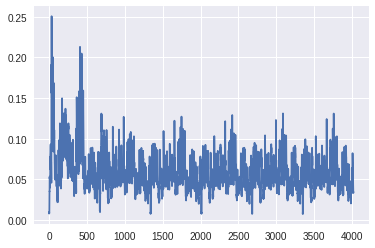

In [16]:
plt.plot(losses)

In [0]:
TEST_DIR = 'bowl/stage1_test/'
test_ids = os.listdir(TEST_DIR)
test_images = [os.path.join(TEST_DIR, test_id, 'images', test_id + '.png') 
                for test_id in test_ids]

In [0]:
test_dataset = DSB2018Dataset(TEST_DIR, test_ids, train=False)

In [64]:
batch_x = np.expand_dims(np.swapaxes(test_dataset[0]['image'], 0, 2), 0) / 255.0
batch_x = Variable(torch.FloatTensor(batch_x)).cuda()
print(batch_x.size())
pred = model1(batch_x)
print(pred.size())
pred.max()

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


Variable containing:
 10.1626
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [0]:
from skimage.morphology import label

def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [0]:
from skimage.transform import resize
image_ids = []
rles = []
model.eval()

for test in test_dataset:
    batch_x = np.expand_dims(np.swapaxes(test['image'], 0, 2), 0) / 255.0
    batch_x = Variable(torch.FloatTensor(batch_x)).cuda()
    
    prediction = model1(batch_x)[0, 0].data.cpu().numpy()
    
    for rle in prob_to_rles(prediction):
        image_ids.append(test['img_id'])
        rles.append(rle)

In [0]:

submission = pd.DataFrame(data={'ImageId': image_ids,
                                'EncodedPixels': [' '.join(map(str, x)) for x in rles]})

In [30]:
submission.head(1)

,EncodedPixels,ImageId
0,1 36 513 8 527 22 1025 7 1037 25 1537 7 1549 2...,17b9bf4356db24967c4677b8376ac38f826de73a88b93a...


In [0]:
submission.to_csv(submission_path + submission_file, index=None)

In [42]:
!ls

0.csv  1.csv  bowl  data  datalab  drive  starterkit-2.csv  sub.csv


In [0]:
!cp starterkit-2.csv drive/bowl/submissions/